<a href="https://colab.research.google.com/github/gk24015/AR_Email/blob/master/Sentiment_FHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Author:Gulshan Kumar
###create key and key2 folder and upload the sentiment_fhe_model folder from download

In [ ]:
!pip install concrete-ml transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.6/671.6 kB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 121.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Let's import a few requirements
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy

class TransformerVectorizer:
    def __init__(self):
        # Load the tokenizer (converts text to tokens)
        self.tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

        # Load the pre-trained model
        self.transformer_model = AutoModelForSequenceClassification.from_pretrained(
            "cardiffnlp/twitter-roberta-base-sentiment-latest"
        )
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"

    def text_to_tensor(
        self,
        texts: list,
    ) -> numpy.ndarray:
        """Function that transforms a list of texts to their learned representation.

        Args:
            list_text_X (list): List of texts to be transformed.

        Returns:
            numpy.ndarray: Transformed list of texts.
        """
        # First, tokenize all the input text
        tokenized_text_X_train = self.tokenizer.batch_encode_plus(
            texts, return_tensors="pt"
        )["input_ids"]

        # Depending on the hardware used, the number of examples to be processed can be reduced
        # Here we split the data into 100 examples per batch
        tokenized_text_X_train_split = torch.split(tokenized_text_X_train, split_size_or_sections=50)

        # Send the model to the device
        transformer_model = self.transformer_model.to(self.device)
        output_hidden_states_list = []

        for tokenized_x in tokenized_text_X_train_split:
            # Pass the tokens through the transformer model and get the hidden states
            # Only keep the last hidden layer state for now
            output_hidden_states = transformer_model(tokenized_x.to(self.device), output_hidden_states=True)[
                1
            ][-1]
            # Average over the tokens axis to get a representation at the text level.
            output_hidden_states = output_hidden_states.mean(dim=1)
            output_hidden_states = output_hidden_states.detach().cpu().numpy()
            output_hidden_states_list.append(output_hidden_states)

        self.encodings = numpy.concatenate(output_hidden_states_list, axis=0)
        return self.encodings

    def transform(self, texts: list):
        return self.text_to_tensor(texts)



In [ ]:

import platform
import sys
import time
from shutil import copyfile
from tempfile import TemporaryDirectory

import numpy
from sklearn.datasets import load_breast_cancer

from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer
from concrete.ml.sklearn import XGBClassifier

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [ ]:
# Let's create the client and load the model
fhemodel_client = FHEModelClient('Key', key_dir='Key2')

In [ ]:



# The client first need to create the private and evaluation keys.
fhemodel_client.generate_private_and_evaluation_keys()

# Get the serialized evaluation keys
serialized_evaluation_keys = fhemodel_client.get_serialized_evaluation_keys()
numpy.save(f"serialized_evaluation_keys.npy", serialized_evaluation_keys)

In [ ]:

# Evaluation keys can be quite large files but only have to be shared once with the server.

# Check the size of the evaluation keys (in MB)
print(f"Evaluation keys size: {sys.getsizeof(serialized_evaluation_keys) / 1024 / 1024:.2f} MB")


Evaluation keys size: 106.39 MB


In [ ]:
from requests import head

from concrete.ml.deployment import FHEModelClient
import numpy
import os
from pathlib import Path
import requests
import json
import base64
import subprocess
import shutil
import time

In [ ]:
transformer_vectorizer = TransformerVectorizer()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from fastapi import FastAPI
from joblib import load
from concrete.ml.deployment import FHEModelServer
from pydantic import BaseModel
import base64
from pathlib import Path
import os

# Set the current directory to the appropriate path in Google Colab


# Path to the sentiment model deployment directory


# Create an instance of the FHEModelServer
fhe_model = FHEModelServer("sentiment_fhe_model/deployment")



In [ ]:
def encode_quantize_encrypt(text):

    encodings = transformer_vectorizer.transform([text])
    quantized_encodings = fhemodel_client.model.quantize_input(encodings).astype(numpy.uint8)
    encrypted_quantized_encoding = fhemodel_client.quantize_encrypt_serialize(encodings)
    print(encrypted_quantized_encoding)
    # Save encrypted_quantized_encoding in a file, since too large to pass through regular Gradio
    # buttons, https://github.com/gradio-app/gradio/issues/1877
    #numpy.save(f"tmp/tmp_encrypted_quantized_encoding_{user_id}.npy", encrypted_quantized_encoding)
    numpy.save("encrypted_quantized_encoding.npy", encrypted_quantized_encoding)
    # Compute size
    encrypted_quantized_encoding_shorten = list(encrypted_quantized_encoding)[:500]
    encrypted_quantized_encoding_shorten_hex = ''.join(f'{i:02x}' for i in encrypted_quantized_encoding_shorten)
    return (
        encodings[0],
        quantized_encodings[0],
        encrypted_quantized_encoding_shorten_hex,

    )


In [ ]:
def run_fhe():
    encrypted_quantized_encoding = numpy.load("encrypted_quantized_encoding.npy")

    # Use base64 to encode the encodings and evaluation key
    encrypted_quantized_encoding = base64.b64encode(encrypted_quantized_encoding).decode()
    serialized_evaluation_keys=numpy.load("serialized_evaluation_keys.npy")
    encoded_evaluation_key = base64.b64encode(serialized_evaluation_keys).decode()

    query = {}
    evaluation_key = base64.b64decode(encoded_evaluation_key)
    encrypted_encoding = base64.b64decode(encrypted_quantized_encoding)
    prediction = fhe_model.run(encrypted_encoding, evaluation_key)
    encoded_prediction = prediction
    ##client
    ##this encoded prediction is passed to client side where it will become encrpted prediction
    encrypted_prediction=encoded_prediction
    numpy.save("encrypted_prediction.npy", encrypted_prediction)
    # Save encrypted_prediction in a file, since too large to pass through regular Gradio
    # buttons, https://github.com/gradio-app/gradio/issues/1877

    encrypted_prediction_shorten = list(encrypted_prediction)[:500]
    encrypted_prediction_shorten_hex = ''.join(f'{i:02x}' for i in encrypted_prediction_shorten)
    return encrypted_prediction_shorten_hex


In [ ]:
def decrypt_prediction():


    # Read encrypted_prediction from the file
    encrypted_prediction = numpy.load("encrypted_prediction.npy").tobytes()

    fhe_api = FHEModelClient("sentiment_fhe_model/deployment")
    fhe_api.load()

    # We need to retrieve the private key that matches the client specs (see issue #18)
    fhe_api.generate_private_and_evaluation_keys(force=False)

    predictions = fhe_api.deserialize_decrypt_dequantize(encrypted_prediction)
    return {
        "negative": predictions[0][0],
        "neutral": predictions[0][1],
        "positive": predictions[0][2],
    }

In [ ]:
[encodings,quantized_encodings,encrypted_quantized_encoding_shorten_hex]=encode_quantize_encrypt("The credit card feature is very bad , my phone keeps on hanging")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
encrypted_quantized_encoding_shorten_hex

'0103000000000000000100000000000000000300000000000001080000000000004000000000000000002bb2a80f5d840c433fdc99f969e24945b4674b0aee49f5e4f6f09b6208b59818712bd9d27d05699cde41bd52a2f3b6c1e964ba6c470a0be960963c6ce1c4753c4c9e9d93e8c303c0eb303dad878f55d41f329ebd144db9c5c4d9b991874f6fb62247c2a923d4f10fbf532491f76f7af16439313c37a250980c31611a53a1045cc232beeab2e2918e5c3aa7023dcd499ac164c60101060b4118907b16917a4afe948c94e1c059f7acd7c02b020af1b0275f235665c5aa4d2945d32eb1055a215ec02b8c8b46eec5771b65b79cd91e5bfd78fa5d353deafd4fa7b78afe30f0f0d311abc1ca42c08f9a2f38e45384b7fc11b6210649f63b44d0a3f3781ca7a274ea340961bd6361e848013f2e14556134bece49332251476ec53c897d429b76a324b37e8ee6c3099ab0b1f21278b265742271db2244f1214d89c87b3c4e8b408cd5369b5a8c682ad345e77041bb5357241d94610b512c39e9c187ffb387cb9840d6eb286d840f9224c62ba186f9213d66a93507eb9492b485e5501f1817c8b20ca94c1062488d5738cf904bcf4095a91a3e75e83c40463eebff816f1c85921f783efd166d0a5010c50fc0937bad662096f1c2609a0a6a6b66dc765cadfaecacb1f6a0097e108eaf4d6468a

In [ ]:
encoded_prediction=run_fhe()

In [ ]:
encoded_prediction

'0104000000000000000100000000000000030000000000000032000000000000000108000000000000400000000000000000000000005077b2280000003c54384d7000000050b68be54f000000942ba0cbed000000ec2efbf0d5000000b8efea39e60000008424f2ac29000000c297756a87000000f139331bb5000000506a058fb500000010abc27c28000000b0f21b5ab6000000a00ec97c22000000e8d00bfd0a00000020f520dbc60000004e4a082fde00000080bdae4555000000c90429b88f000000c06a9d794a00000010fd05eabd000000f7ed09645c000000388ac10d0b000000770e7cc95d000000a4a89cc8fa000000a00dac7b52000000b8b11d6505000000b83f7eced7000000981a66c57a0000006f4128d21e00000020884557f3000000a4eb6ed4d9000000fc66ffeff1000000f634ed1bb3000000db20dee4a2000000780f1a87bc000000a0c33233540000000af5558de7000000fe4268d049000000a0a399a6070000007c5cca28fe0000007c3c2f887200000094e6456c7f000000d16631fbfc000000c47a06aadb000000c8cd0dae4d000000ced97d870700000050b49ec6e300000080f72186fc000000c48cb72373000000e0b7583e2f000000b835037339000000e0ca2c5776000000d0672a0e18000000d40cc3390c000000bd2a318ddb000000c808d541bb000

In [ ]:
sentiment=decrypt_prediction()

In [ ]:
sentiment

{'negative': 0.692386659380271,
 'neutral': 0.09077624924184291,
 'positive': 0.21683709137788607}

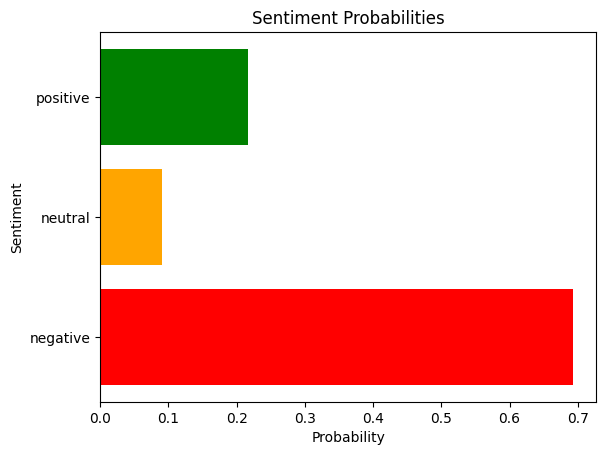

In [ ]:
import matplotlib.pyplot as plt

# Sentiment predictions (replace these with your actual predictions)
sentiment_predictions = sentiment

# Extracting labels and probabilities
labels = list(sentiment_predictions.keys())
probabilities = list(sentiment_predictions.values())

# Plotting the horizontal bar chart
plt.barh(labels, probabilities, color=['red', 'orange', 'green'],linewidth=1)

# Adding title and labels
plt.title('Sentiment Probabilities')
plt.xlabel('Probability')
plt.ylabel('Sentiment')

# Show the plot
plt.show()
